## Model evaluation

Multi-class classification: stars from 1 to 5

In [1]:
using Flux
using Flux: DataLoader
using Plots
using DataFrames
using Printf
using BSON, JSON
using Arrow
using StatsBase
using Unicode
using Random

In [2]:
using Revise
#using TokenizersLite # https://github.com/LiorSinai/TokenizersLite
using TransformersLite

In [3]:
include("../../common/reporting.jl")
include("../../common/vocab.jl")
include("../../common/training.jl")

update_history! (generic function with 1 method)

In [4]:
nlabels = 5;

## Download data

Run `python download_amazon_reviews.py`.

Requires Python and the `datasets` package by HuggingFace.

## Load data

raw

In [5]:
fingerprint = "724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609"
data_dir = joinpath("..\\..\\datasets\\amazon_reviews_multi\\en\\1.0.0\\", fingerprint)
file_train = "amazon_reviews_multi-train.arrow"
file_test = "amazon_reviews_multi-test.arrow" ;

In [6]:
filepath = joinpath(data_dir, file_train)
df = DataFrame(Arrow.Table(filepath))
println("rows: ", nrow(df))

filepath = joinpath(data_dir, file_test)
df_test = DataFrame(Arrow.Table(filepath));
println("rows: ", nrow(df_test))

rows: 200000
rows: 5000


filtered

In [7]:
documents = df[:, :review_body]
labels = df[:, :stars]

println("training samples: ", size(documents), " ", size(labels))

training samples: (200000,) (200000,)


In [8]:
documents_test = df_test[:, "review_body"]
labels_test = df_test[:, "stars"];

println("test samples: ", size(documents_test), " ", size(labels_test))

test samples: (5000,) (5000,)


models

In [9]:
directory = "outputs/20240212_n5"
saved_objects = BSON.load(joinpath(directory, "model.bson"))

Dict{Symbol, Any} with 3 entries:
  :tokenizer => identity
  :indexer   => IndexTokenizer{String}(length(vocabulary)=6996, unksym=[UNK])
  :model     => TransformerClassifier{Embedding{Matrix{Float32}}, PositionEncod…

In [10]:
tokenizer = saved_objects[:tokenizer]
@show tokenizer
indexer = saved_objects[:indexer]
@show indexer
model = saved_objects[:model]
display(model)

tokenizer = identity
indexer = IndexTokenizer{String}(length(vocabulary)=6996, unksym=[UNK])


TransformerClassifier(
  Embedding(6996 => 8),                 # 55_968 parameters
  PositionEncoding(8),
  Dropout(0.1),
  [
    TransformerBlock(
      MultiHeadAttention(
        nhead=4,
        denseQ = Dense(8 => 8; bias=false),  # 64 parameters
        denseK = Dense(8 => 8; bias=false),  # 64 parameters
        denseV = Dense(8 => 8; bias=false),  # 64 parameters
        denseO = Dense(8 => 8),         # 72 parameters
      ),
      LayerNorm(8),                     # 16 parameters
      Dense(8 => 32, relu),             # 288 parameters
      Dense(32 => 8),                   # 264 parameters
      LayerNorm(8),                     # 16 parameters
      Dropout(0.1),
    ),
  ],
  Dense(8 => 1),                        # 9 parameters
  FlattenLayer(),
  Dense(50 => 5),                       # 255 parameters
)         # Total: 18 trainable arrays, 57_080 parameters,
          # plus 1 non-trainable, 8_000 parameters, summarysize 255.359 KiB.

In [11]:
max_sentence_length = size(model.head.weight, 2)

50

## Tokenizers

In [12]:
@time tokens = map(d->preprocess(d, tokenizer; max_length=max_sentence_length), documents)
@time indices = indexer(tokens)

y_train = copy(labels)
idxs = Base.OneTo(length(labels))
X_train, y_train = indices[:, idxs], y_train[idxs];
y_train = Flux.onehotbatch(y_train, 1:5) # multi-class
train_data, val_data = split_validation(MersenneTwister(2718), X_train, y_train)

println("train samples:      ", size(train_data[1]), " ", size(train_data[2]))
println("validation samples: ", size(val_data[1]), " ", size(val_data[2]))

  6.415144 seconds (29.41 M allocations: 1.518 GiB, 24.51% gc time, 3.64% compilation time)
  0.463786 seconds (44.84 k allocations: 80.047 MiB, 20.43% gc time, 11.75% compilation time)
train samples:      (50, 180000) (5, 180000)
validation samples: (50, 20000) (5, 20000)


In [13]:
y_test = copy(labels_test)
y_test = Flux.onehotbatch(y_test, 1:5);

@time tokens_test = map(d->preprocess(d, tokenizer; max_length=max_sentence_length), documents_test) 
@time indices_test = indexer(tokens_test)

X_test = indices_test

println("test indices: ", size(indices_test))
println("test samples: ", size(X_test), " ", size(y_test))

  0.200574 seconds (768.24 k allocations: 40.423 MiB, 41.63% compilation time)
  0.013111 seconds (6 allocations: 1.946 MiB)
test indices: (50, 5000)
test samples: (50, 5000) (5, 5000)


In [14]:
train_data_loader = DataLoader(train_data; batchsize=64, shuffle=false);
val_data_loader  = DataLoader(val_data; batchsize=64, shuffle=false);

## Evaluate

In [15]:
loss(ŷ::AbstractMatrix, y::AbstractMatrix) = Flux.logitcrossentropy(ŷ, y)
accuracy(ŷ::AbstractMatrix, y::AbstractMatrix) = mean(Flux.onecold(ŷ) .== Flux.onecold(y))

accuracy (generic function with 1 method)

In [16]:
batched_metrics(model, train_data_loader, loss, accuracy)

batch metrics... 100%|███████████████████████████████████| Time: 0:00:59m9mm


(loss = 1.0990934f0, accuracy = 0.5172222f0)

In [17]:
batched_metrics(model, val_data_loader, loss, accuracy)

batch metrics... 100%|███████████████████████████████████| Time: 0:00:05


(loss = 1.1016688f0, accuracy = 0.5153f0)

In [18]:
history = open(joinpath(directory, "history.json"), "r") do f
    JSON.parse(read(f, String))
end

Dict{String, Any} with 5 entries:
  "train_loss"      => Any[1.29479, 1.20416, 1.16426, 1.14167, 1.12597, 1.11264…
  "train_accuracy"  => Any[0.418622, 0.462072, 0.480472, 0.494028, 0.50235, 0.5…
  "mean_batch_loss" => Any[1.49619, 1.27418, 1.21486, 1.18578, 1.16668, 1.15287…
  "val_accuracy"    => Any[0.42135, 0.4618, 0.47895, 0.48645, 0.4926, 0.4983, 0…
  "val_loss"        => Any[1.29312, 1.20807, 1.17338, 1.15504, 1.14325, 1.13319…

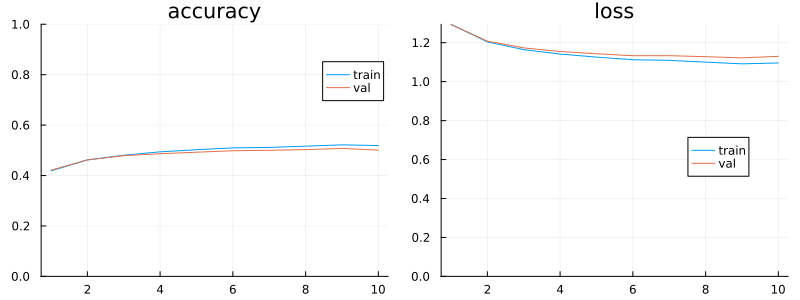

In [19]:
epochs = 1:length(history["train_accuracy"])
p1 = plot(epochs, history["train_accuracy"], label="train")
plot!(p1, epochs, history["val_accuracy"], label="val")
plot!(p1, ylims=[0, 1], title="accuracy", legend=(0.9, 0.8))

p2 = plot(epochs, history["train_loss"], label="train")
plot!(p2, epochs, history["val_loss"], label="val")
plot!(p2, title="loss", ylims=[0, Inf], legend=(0.8, 0.5))

p = plot(p1, p2, layout=grid(1, 2), size=(800, 300))
savefig(p, joinpath(directory, "history.png"))
p

## Test data

In [20]:
logits = model(X_test)
accuracy(logits, y_test)

0.4904

In [21]:
probs = softmax(logits, dims=1)
y_pred = Flux.onecold(probs);

In [22]:
cm = confusion_matrix(vec(y_pred), Flux.onecold(y_test), 1:nlabels)

5×5 Matrix{Int64}:
 791  131   53   10   15
 396  323  203   60   18
 191  281  291  181   56
  32  100  242  369  257
  41   37   52  192  678

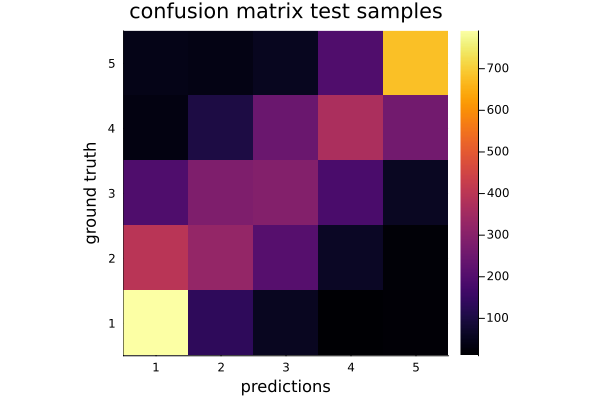

In [23]:
p = heatmap(1:5, 1:5, cm, xlabel="predictions", ylabel="ground truth", xlims=(0.5, nlabels+0.5), aspectratio=1,
    title="confusion matrix test samples", xticks=(1:5)) #, ["negative", "mix", "positive"]))
savefig(p, joinpath(directory, "confusion_matrix.png"))
p

In [24]:
classification_report(cm, 1:nlabels)

              precision  recall  f1-score  support
           1       0.55    0.79      0.65     1000
           2       0.37    0.32      0.35     1000
           3       0.35    0.29      0.32     1000
           4       0.45    0.37      0.41     1000
           5       0.66    0.68      0.67     1000

weighted avg       0.48    0.49      0.48     5000

### Examples

In [25]:
println("star  y  ŷ   prob")
for star in nlabels:-1:1
    pos_max = argmax(probs[star, :])
    @printf("   %1d  %d  %d  %.4f  %s\n\n",
            star, labels_test[pos_max], y_pred[pos_max], probs[star, pos_max], documents_test[pos_max]
        )
end

star  y  ŷ   prob
   5  5  5  0.9328  Fit perfectly into my coach tote! Makes the order very organized and easy to find items. I love it and will buy it in diff colors for other handbags!

   4  3  4  0.8397  This is a good read. Characters are likable and a bit quirky for mystery/crime. The story is a bit thin, but an easy and enjoyable read.

   3  3  3  0.5485  ok. Typical Chinese

   2  2  2  0.5228  These nesting dolls are very pretty. Very nice work and that is why I'm giving them 2 stars. However, the second doll seems to have been shellacked shut. It is impossible to open. Even my husband tried prying them. It is impossible. I think it is ridiculous that the purpose of this toy is to be able to be opened (by a child) and they cannot even be opened by a grown man. I bought them even though I saw that in someone else's review, and I wish I didn't because they cannot be returned. So, now I'm stuck with a set of nesting dolls and I can only open the first one. Totally disappointing

In [26]:
nshow = 2

for label in 1:nlabels
    println("\ntrue label = $label")
    idxs = labels_test .== label
    idxs_label = (1:length(labels_test))[vec(idxs)]
    idxs_correct = idxs_label[y_pred[idxs] .== label]
    idxs_wrong = idxs_label[y_pred[idxs] .!== label]
    @printf("correct: %d / %d\n", length(idxs_correct), length(idxs_label))
    println(" idx  y  ŷ    prob  ")
    for idxs_subset in [idxs_correct, idxs_wrong]
        for idx in sample(idxs_subset, nshow, replace=false)
            println("-"^100)
            @printf("%4d  %d  %d  %.4f  %s\n",
                idx, labels_test[idx], y_pred[idx], probs[idx], documents_test[idx]
            )
        end
    end
    println("")
end


true label = 1
correct: 791 / 1000
 idx  y  ŷ    prob  
----------------------------------------------------------------------------------------------------
 973  1  1  0.0670  Horrible all around. My girlfriend got one for herself and it works great. I got one for my mother’s room thinking it would help her sleep and it never worked
----------------------------------------------------------------------------------------------------
  82  1  1  0.3340  Phone has scratches all over it after less than a month of regular using
----------------------------------------------------------------------------------------------------
 390  1  3  0.0364  One of the boxes I bought of this cereal had live bugs in it. The other 3 were fine.
----------------------------------------------------------------------------------------------------
 483  1  2  0.1105  Only a couple weeks after mounting using the included adhesive, the mount gave out and dropped my Rift ruining the display. The included adhes

### Probabilities

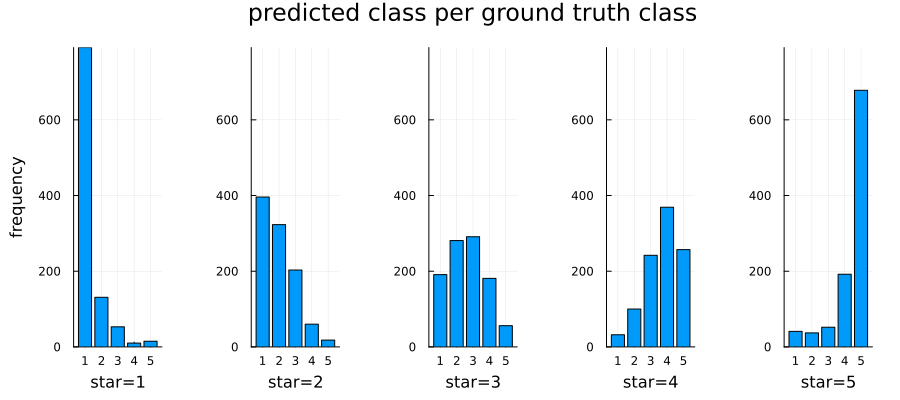

In [27]:
canvases = []
label_names = 1:5
for gt_star in 1:5
    idxs = labels_test .== gt_star
    value_counts = [sum((y_pred[idxs]) .== l) for l in 1:nlabels]
    p = bar(value_counts, xlabel="star=$gt_star",legend=:none, xticks=(1:nlabels, 1:5))#["neg", "mix", "pos"]))
    push!(canvases, p)
end
plot!(canvases[1], ylabel="frequency")
p =plot(canvases..., layout=(1, 5), link=:y, size=(900, 400), plot_title="predicted class per ground truth class",
    margin=5Plots.mm)
savefig(p, joinpath(directory, "prediction_star.png"))
p

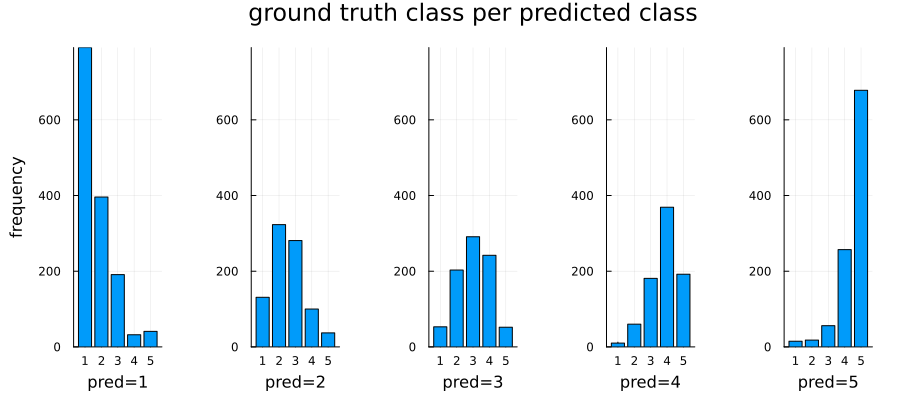

In [28]:
canvases = []
label_names = 1:5
for pred_star in 1:5
    idxs = y_pred .== pred_star
    value_counts = [sum((labels_test[idxs]) .== l) for l in 1:nlabels]
    p = bar(value_counts, xlabel="pred=$pred_star",legend=:none, xticks=(1:nlabels, 1:5))#["neg", "mix", "pos"]))
    push!(canvases, p)
end
plot!(canvases[1], ylabel="frequency")
p =plot(canvases..., layout=(1, 5), link=:y, size=(900, 400), plot_title="ground truth class per predicted class",
    margin=5Plots.mm)
savefig(p, joinpath(directory, "star_prediction.png"))
p

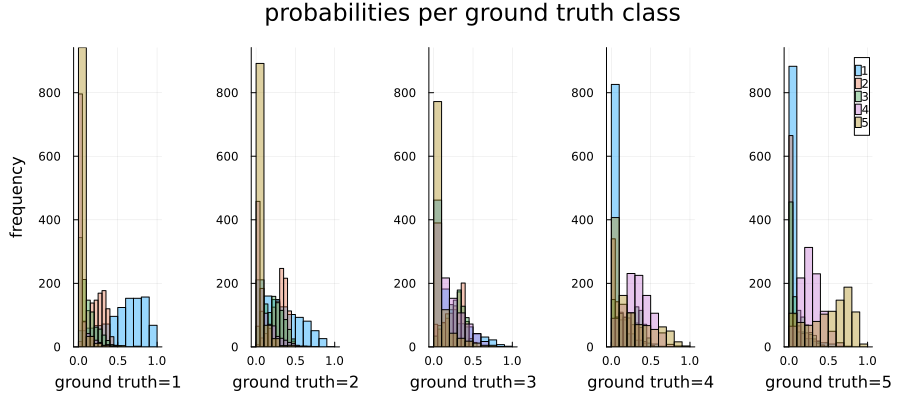

In [29]:
canvases = []
label_names = 1:5
for groundtruth_star in 1:5
    idxs = labels_test .== groundtruth_star
    probs_star = probs[:, idxs]
    p = plot(xlabel="ground truth=$groundtruth_star", legend=:none, xticks=([0.00, 0.50, 1.00]))
    for pred_star in 1:nlabels
        histogram!(probs_star[pred_star, :], fillalpha=0.4, label=label_names[pred_star], nbins=12)
    end
    push!(canvases, p)
end
plot!(canvases[1], ylabel="frequency")
plot!(canvases[5], legend=:best)
p =plot(canvases..., layout=(1, 5), link=:y, size=(900, 400), plot_title="probabilities per ground truth class",
    margin=5Plots.mm)
savefig(p, joinpath(directory, "probabilites_star.png"))
p

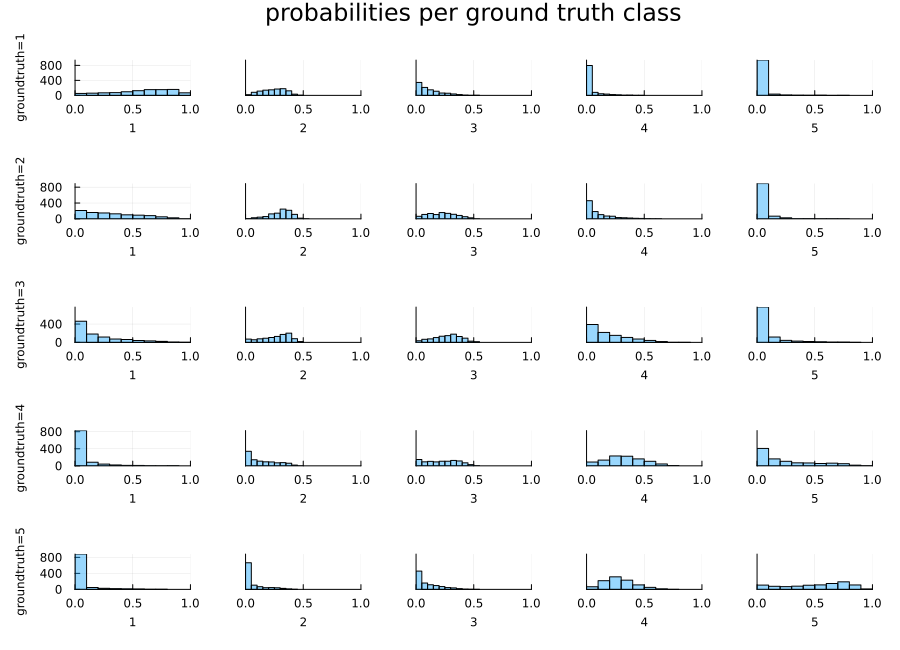

In [30]:
canvases = []
label_names = 1:5
for groundtruth_star in 1:5
    idxs = labels_test .== groundtruth_star
    probs_star = probs[:, idxs]
    #p = plot(xlabel="ground truth=$groundtruth_star", legend=:none, xticks=([0.00, 0.50, 1.00]))
    for pred_star in 1:nlabels
        p = histogram(probs_star[pred_star, :], fillalpha=0.4, label="", nbins=12,  
            xlims=[0, 1], xticks=([0.00, 0.50, 1.00]), yticks=([]), xlabel="$pred_star", xguidefontsize=8)
        push!(canvases, p)
    end
end

for groundtruth_star in 1:5
    plot!(canvases[1 + 5 * (groundtruth_star - 1)], ylabel="groundtruth=$groundtruth_star", yguidefontsize=8,
        yticks=([0, 400, 800])
    )
end
    
p =plot(canvases..., layout=(5, 5), link=:y, size=(900, 650), plot_title="probabilities per ground truth class",
    margin=5Plots.mm)
savefig(p, joinpath(directory, "probabilites_star_grid.png"))
p

### Single sample

In [31]:
idx = 4600 

d = documents_test[idx]
println(labels_test[idx])
println(d)
println("")

tokens = preprocess(d, tokenizer; max_length=50)
println(join(tokens, "|"))
println("")

x = indexer(tokens)
x = vcat(x, ones(Int, 50 - length(x)))
println(join(x, "|"))

5
I used for a party and was great !

used|for|party|and|was|great

84|6|776|3|14|25|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1


In [32]:
model.embedding(x)

8×50 Matrix{Float32}:
 -0.888094    0.291673  -0.825528    -1.11514   …   0.00765884   0.00765884
  0.195314   -0.453157  -0.207063     0.730117     -0.171406    -0.171406
  0.0790065   0.205835  -0.00394392   2.8094        1.52581      1.52581
  0.933375   -0.257193   1.6227       0.783601      0.431819     0.431819
 -0.0261238   0.378939  -0.241607     0.65322       0.299956     0.299956
 -0.16962    -1.6316     0.169626    -1.28475   …  -1.04329     -1.04329
 -0.307429   -0.143642  -1.7087      -0.908977      0.174601     0.174601
  0.505454    1.02852    0.491171    -0.577929     -1.11969     -1.11969

In [33]:
softmax(model(x))

5×1 Matrix{Float32}:
 0.0014633912
 0.008057895
 0.032145575
 0.2697457
 0.6885875